In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json
from glob import glob
from collections import namedtuple

import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm as scp_norm

from bbb.utils.pytorch_setup import DEVICE
from bbb.utils.plotting import plot_weight_samples
from bbb.data import generate_regression_data
from bbb.config.constants import KL_REWEIGHTING_TYPES, PRIOR_TYPES, VP_VARIANCE_TYPES
from bbb.config.parameters import Parameters, PriorParameters
from bbb.models.dnn import RegressionDNN
from bbb.models.bnn import RegressionBNN
from bbb.data import load_mnist

### Matplotlib Setup

In [3]:
plt.rcParams.update({'axes.titlesize': 'large', 'axes.labelsize': 'medium'})
colors_hex = {'blue': '#1F77B4', 'orange': '#FF7F0E', 'green': '#2CA02C'}
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

## Load Data

In [4]:
train_data = generate_regression_data(train=True, size=1000, batch_size=1000, shuffle=True)
test_data = generate_regression_data(train=False, size=1000, batch_size=1000, shuffle=True)

In [5]:
input_np = test_data.dataset[:][0].detach().numpy().flatten()
output_np = test_data.dataset[:][1].detach().numpy().flatten()

## Helper Classes

In [6]:
DnnModelDetails = namedtuple('ModelDetails', 'dir mclass do label')
BnnModelDetails = namedtuple('ModelDetails', 'dir mclass lrt s1 s2 m label')

## Trained Regression Models

In [23]:
BNN_MODELS = {
    # Single Gaussian Prior
    "bnn_sigma_1_exp_0_1": BnnModelDetails("../saved_models/BBB_regression/baseline/single_gaussian_prior/sigma_1_exp_0/2022-03-26-21.49.23", RegressionBNN, lrt=False, s1=np.exp(-0), s2=None, m=None, label=r'$\sigma_1=\exp^{-0}'),
    "bnn_sigma_1_exp_0_2": BnnModelDetails("../saved_models/BBB_regression/baseline/single_gaussian_prior/sigma_1_exp_0/2022-03-26-22.01.03", RegressionBNN, lrt=False, s1=np.exp(-0), s2=None, m=None, label=r'$\sigma_1=\exp^{-0}'),
    "bnn_sigma_1_exp_0_3": BnnModelDetails("../saved_models/BBB_regression/baseline/single_gaussian_prior/sigma_1_exp_0/2022-03-26-22.13.29", RegressionBNN, lrt=False, s1=np.exp(-0), s2=None, m=None, label=r'$\sigma_1=\exp^{-0}'),
    "bnn_sigma_1_exp_1_1": BnnModelDetails("../saved_models/BBB_regression/baseline/single_gaussian_prior/sigma_1_exp_1/2022-03-26-22.24.50", RegressionBNN, lrt=False, s1=np.exp(-1), s2=None, m=None, label=r'$\sigma_1=\exp^{-1}'),
    "bnn_sigma_1_exp_1_2": BnnModelDetails("../saved_models/BBB_regression/baseline/single_gaussian_prior/sigma_1_exp_1/2022-03-27-10.13.58", RegressionBNN, lrt=False, s1=np.exp(-1), s2=None, m=None, label=r'$\sigma_1=\exp^{-1}'),
    "bnn_sigma_1_exp_1_3": BnnModelDetails("../saved_models/BBB_regression/baseline/single_gaussian_prior/sigma_1_exp_1/2022-03-27-10.27.55", RegressionBNN, lrt=False, s1=np.exp(-1), s2=None, m=None, label=r'$\sigma_1=\exp^{-1}'),
    "bnn_sigma_1_exp_2_1": BnnModelDetails("../saved_models/BBB_regression/baseline/single_gaussian_prior/sigma_1_exp_2/2022-03-27-10.53.53", RegressionBNN, lrt=False, s1=np.exp(-2), s2=None, m=None, label=r'$\sigma_1=\exp^{-2}'),
    "bnn_sigma_1_exp_2_2": BnnModelDetails("../saved_models/BBB_regression/baseline/single_gaussian_prior/sigma_1_exp_2/2022-03-27-11.25.29", RegressionBNN, lrt=False, s1=np.exp(-2), s2=None, m=None, label=r'$\sigma_1=\exp^{-2}'),
    "bnn_sigma_1_exp_2_3": BnnModelDetails("../saved_models/BBB_regression/baseline/single_gaussian_prior/sigma_1_exp_2/2022-03-27-11.41.16", RegressionBNN, lrt=False, s1=np.exp(-2), s2=None, m=None, label=r'$\sigma_1=\exp^{-2}'),
    "bnn_lrt_sigma_1_exp_0": BnnModelDetails("../saved_models/BBB_regression/lrt/single_gaussian_prior/sigma_1_exp_0/2022-03-27-12.42.30", RegressionBNN, lrt=True, s1=np.exp(-0), s2=None, m=None,   label=r'LRT - $\sigma_1=\exp^{-0}'),
    "bnn_lrt_sigma_1_exp_1": BnnModelDetails("../saved_models/BBB_regression/lrt/single_gaussian_prior/sigma_1_exp_1/2022-03-27-12.53.21", RegressionBNN, lrt=True, s1=np.exp(-1), s2=None, m=None,   label=r'LRT - $\sigma_1=\exp^{-1}'),
    "bnn_lrt_sigma_1_exp_2": BnnModelDetails("../saved_models/BBB_regression/lrt/single_gaussian_prior/sigma_1_exp_2/2022-03-27-13.03.52", RegressionBNN, lrt=True, s1=np.exp(-2), s2=None, m=None,   label=r'LRT - $\sigma_1=\exp^{-1}'),
    # MoG Prior
    "bnn_sigma_1_exp_0_sigma_2_exp_6_m50": BnnModelDetails("../saved_models/BBB_regression/baseline/mog_prior/sigma_1_exp_0_sigma_2_exp_6/2022-03-27-16.09.33", RegressionBNN, lrt=False, s1=np.exp(-0), s2=np.exp(-6), m=0.5, label=r'$\sigma_1=\exp^{-0}, \sigma_2=\exp^{-6}, m=0.5$'),
    "bnn_sigma_1_exp_0_sigma_2_exp_7_m50": BnnModelDetails("../saved_models/BBB_regression/baseline/mog_prior/sigma_1_exp_0_sigma_2_exp_7/2022-03-27-16.21.55", RegressionBNN, lrt=False, s1=np.exp(-0), s2=np.exp(-7), m=0.5, label=r'$\sigma_1=\exp^{-0}, \sigma_2=\exp^{-7}, m=0.5$'),
    "bnn_sigma_1_exp_0_sigma_2_exp_8_m50": BnnModelDetails("../saved_models/BBB_regression/baseline/mog_prior/sigma_1_exp_0_sigma_2_exp_8/2022-03-27-16.35.03", RegressionBNN, lrt=False, s1=np.exp(-0), s2=np.exp(-8), m=0.5, label=r'$\sigma_1=\exp^{-0}, \sigma_2=\exp^{-8}, m=0.5$'),
    "bnn_sigma_1_exp_1_sigma_2_exp_6_m50": BnnModelDetails("../saved_models/BBB_regression/baseline/mog_prior/sigma_1_exp_1_sigma_2_exp_6/2022-03-27-16.47.36", RegressionBNN, lrt=False, s1=np.exp(-1), s2=np.exp(-6), m=0.5, label=r'$\sigma_1=\exp^{-1}, \sigma_2=\exp^{-6}, m=0.5$'),
    "bnn_sigma_1_exp_1_sigma_2_exp_7_m50": BnnModelDetails("../saved_models/BBB_regression/baseline/mog_prior/sigma_1_exp_1_sigma_2_exp_7/2022-03-27-16.59.37", RegressionBNN, lrt=False, s1=np.exp(-1), s2=np.exp(-7), m=0.5, label=r'$\sigma_1=\exp^{-1}, \sigma_2=\exp^{-7}, m=0.5$'),
    "bnn_sigma_1_exp_1_sigma_2_exp_8_m50": BnnModelDetails("../saved_models/BBB_regression/baseline/mog_prior/sigma_1_exp_1_sigma_2_exp_8/2022-03-27-17.16.54", RegressionBNN, lrt=False, s1=np.exp(-1), s2=np.exp(-8), m=0.5, label=r'$\sigma_1=\exp^{-1}, \sigma_2=\exp^{-8}, m=0.5$'),
    "bnn_sigma_1_exp_2_sigma_2_exp_6_m50": BnnModelDetails("../saved_models/BBB_regression/baseline/mog_prior/sigma_1_exp_2_sigma_2_exp_6/2022-03-27-18.21.23", RegressionBNN, lrt=False, s1=np.exp(-2), s2=np.exp(-6), m=0.5, label=r'$\sigma_1=\exp^{-2}, \sigma_2=\exp^{-6}, m=0.5$'),
    "bnn_sigma_1_exp_2_sigma_2_exp_7_m50": BnnModelDetails("../saved_models/BBB_regression/baseline/mog_prior/sigma_1_exp_2_sigma_2_exp_7/2022-03-27-18.51.26", RegressionBNN, lrt=False, s1=np.exp(-2), s2=np.exp(-7), m=0.5, label=r'$\sigma_1=\exp^{-2}, \sigma_2=\exp^{-7}, m=0.5$'),
    "bnn_sigma_1_exp_2_sigma_2_exp_8_m50": BnnModelDetails("../saved_models/BBB_regression/baseline/mog_prior/sigma_1_exp_2_sigma_2_exp_8/2022-03-27-18.57.57", RegressionBNN, lrt=False, s1=np.exp(-2), s2=np.exp(-8), m=0.5, label=r'$\sigma_1=\exp^{-2}, \sigma_2=\exp^{-8}, m=0.5$'),
    # "bnn_lrt_sigma_1_exp_0": BnnModelDetails("../saved_models/BBB_regression/lrt/sigma_1_exp_0_sigma_2_exp_6/2022-03-27-12.42.30", RegressionBNN, lrt=True, s1=np.exp(-0), s2=None, m=None,   label=r'LRT - $\sigma_1=\exp^{-0}, \sigma_2=\exp^{-6}, m=0.5$'),
    # "bnn_lrt_sigma_1_exp_1": BnnModelDetails("../saved_models/BBB_regression/lrt/sigma_1_exp_1_sigma_2_exp_6/2022-03-27-12.53.21", RegressionBNN, lrt=True, s1=np.exp(-1), s2=None, m=None,   label=r'LRT - $\sigma_1=\exp^{-1}, \sigma_2=\exp^{-6}, m=0.5$'),
    # "bnn_lrt_sigma_1_exp_2": BnnModelDetails("../saved_models/BBB_regression/lrt/sigma_1_exp_2_sigma_2_exp_6/2022-03-27-13.03.52", RegressionBNN, lrt=True, s1=np.exp(-2), s2=None, m=None,   label=r'LRT - $\sigma_1=\exp^{-1}, \sigma_2=\exp^{-6}, m=0.5$'),
}

In [24]:
MODEL_DETAILS_DICT = {    
    # DNN Baseline
    "dnn_baseline_1": DnnModelDetails("../saved_models/DNN_regression/baseline/2022-03-26-21.10.59", RegressionDNN, do=None, label='DNN'),
    "dnn_baseline_2": DnnModelDetails("../saved_models/DNN_regression/baseline/2022-03-26-21.11.36", RegressionDNN, do=None, label='DNN'),
    # DNN DO Baseline
    "dnn_do_50_baseline": DnnModelDetails("../saved_models/DNN_regression/dropout/0.5/2022-03-26-22.02.19", RegressionDNN, do=0.5, label=r'$\rho=0.5$'),
    "dnn_do_75_baseline": DnnModelDetails("../saved_models/DNN_regression/dropout/0.75/2022-03-26-22.13.57", RegressionDNN, do=0.75, label=r'$\rho=0.75$'),
}
MODEL_DETAILS_DICT.update(BNN_MODELS)

Text(0, 0.5, 'ELBO')

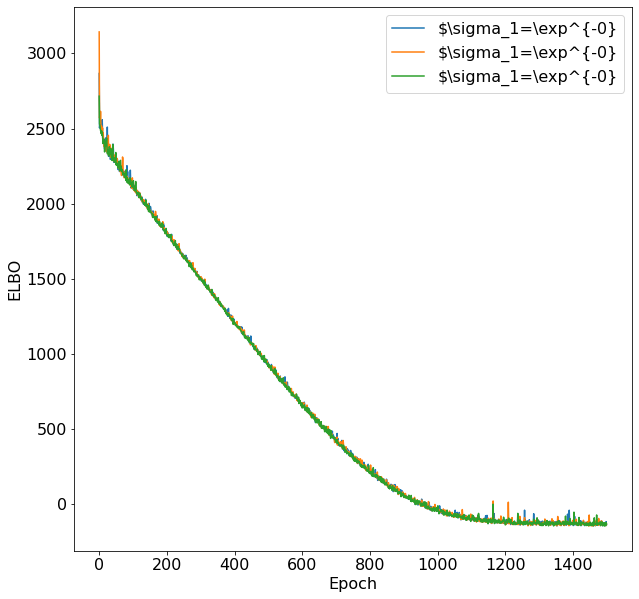

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))

for model in ['bnn_sigma_1_exp_0_1', 'bnn_sigma_1_exp_0_2', 'bnn_sigma_1_exp_0_3']:
# for model in ['bnn_sigma_1_exp_1_1', 'bnn_sigma_1_exp_1_2', 'bnn_sigma_1_exp_1_3']:
# for model in ['bnn_sigma_1_exp_2_1', 'bnn_sigma_1_exp_2_2', 'bnn_sigma_1_exp_2_3']:
    model_details = MODEL_DETAILS_DICT[model]
    loss = np.load(os.path.join(model_details.dir, 'loss.npy'))
    ax.plot(loss, label=model_details.label)
ax.legend()
ax.set_xlabel('Epoch')
ax.set_ylabel('ELBO')

Text(0, 0.5, 'ELBO')

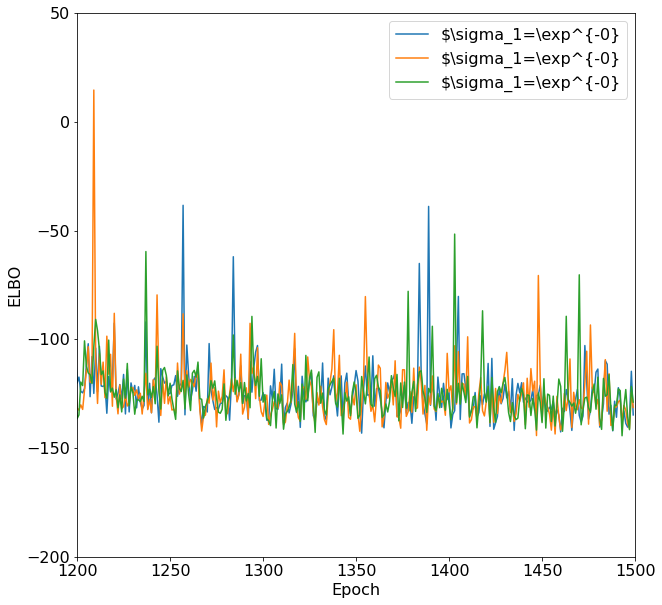

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))

for model in ['bnn_sigma_1_exp_0_1', 'bnn_sigma_1_exp_0_2', 'bnn_sigma_1_exp_0_3']:
# for model in ['bnn_sigma_1_exp_1_1', 'bnn_sigma_1_exp_1_2', 'bnn_sigma_1_exp_1_3']:
# for model in ['bnn_sigma_1_exp_2_1', 'bnn_sigma_1_exp_2_2', 'bnn_sigma_1_exp_2_3']:
    model_details = MODEL_DETAILS_DICT[model]
    loss = np.load(os.path.join(model_details.dir, 'loss.npy'))
    ax.plot(loss, label=model_details.label)
ax.set_xlim(1200, 1500)
ax.set_ylim(-200, 50)
ax.legend()
ax.set_xlabel('Epoch')
ax.set_ylabel('ELBO')

Text(0, 0.5, 'ELBO')

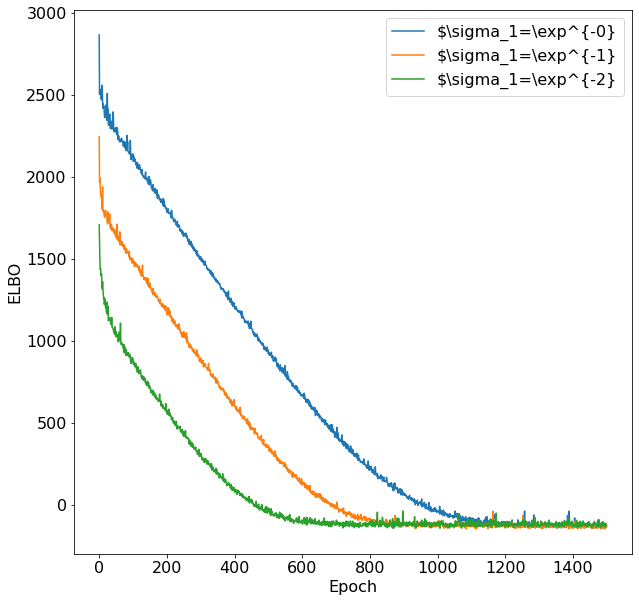

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))

for model in ['bnn_sigma_1_exp_0_1', 'bnn_sigma_1_exp_1_1', 'bnn_sigma_1_exp_2_1']:
# for model in ['bnn_sigma_1_exp_0_2', 'bnn_sigma_1_exp_1_2', 'bnn_sigma_1_exp_2_2']:
# for model in ['bnn_sigma_1_exp_0_3', 'bnn_sigma_1_exp_1_3', 'bnn_sigma_1_exp_2_3']:
    model_details = MODEL_DETAILS_DICT[model]
    loss = np.load(os.path.join(model_details.dir, 'loss.npy'))
    ax.plot(loss, label=model_details.label)
ax.legend()
ax.set_xlabel('Epoch')
ax.set_ylabel('ELBO')

Text(0, 0.5, 'ELBO')

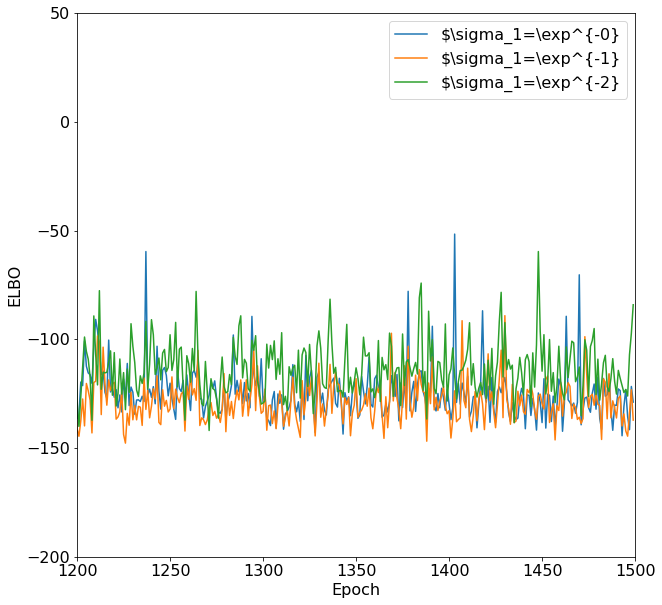

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))

# for model in ['bnn_sigma_1_exp_0_1', 'bnn_sigma_1_exp_1_1', 'bnn_sigma_1_exp_2_1']:
# for model in ['bnn_sigma_1_exp_0_2', 'bnn_sigma_1_exp_1_2', 'bnn_sigma_1_exp_2_2']:
for model in ['bnn_sigma_1_exp_0_3', 'bnn_sigma_1_exp_1_3', 'bnn_sigma_1_exp_2_3']:
    model_details = MODEL_DETAILS_DICT[model]
    loss = np.load(os.path.join(model_details.dir, 'loss.npy'))
    ax.plot(loss, label=model_details.label)
ax.set_xlim(1200, 1500)
ax.set_ylim(-200, 50)
ax.legend()
ax.set_xlabel('Epoch')
ax.set_ylabel('ELBO')

Text(0, 0.5, 'ELBO')

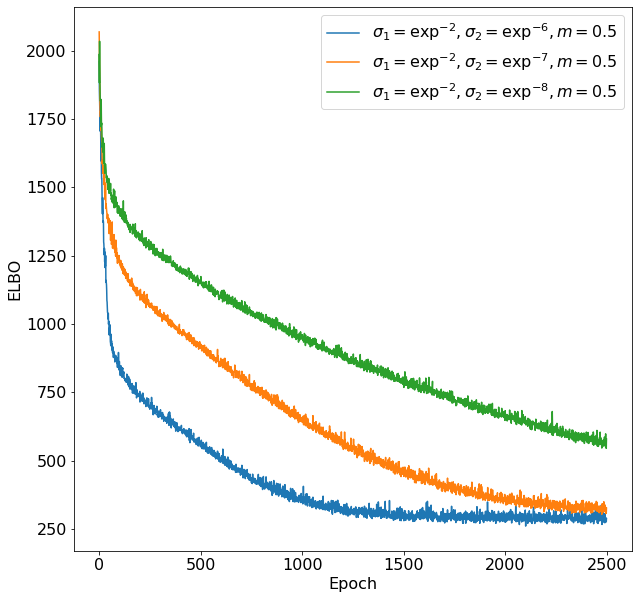

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))

# for model in ['bnn_sigma_1_exp_0_sigma_2_exp_6_m50', 'bnn_sigma_1_exp_0_sigma_2_exp_7_m50', 'bnn_sigma_1_exp_0_sigma_2_exp_8_m50']:
# for model in ['bnn_sigma_1_exp_1_sigma_2_exp_6_m50', 'bnn_sigma_1_exp_1_sigma_2_exp_7_m50', 'bnn_sigma_1_exp_1_sigma_2_exp_8_m50']:
for model in ['bnn_sigma_1_exp_2_sigma_2_exp_6_m50', 'bnn_sigma_1_exp_2_sigma_2_exp_7_m50', 'bnn_sigma_1_exp_2_sigma_2_exp_8_m50']:
    model_details = MODEL_DETAILS_DICT[model]
    loss = np.load(os.path.join(model_details.dir, 'loss.npy'))
    ax.plot(loss, label=model_details.label)
ax.legend()
ax.set_xlabel('Epoch')
ax.set_ylabel('ELBO')

Text(0, 0.5, 'ELBO')

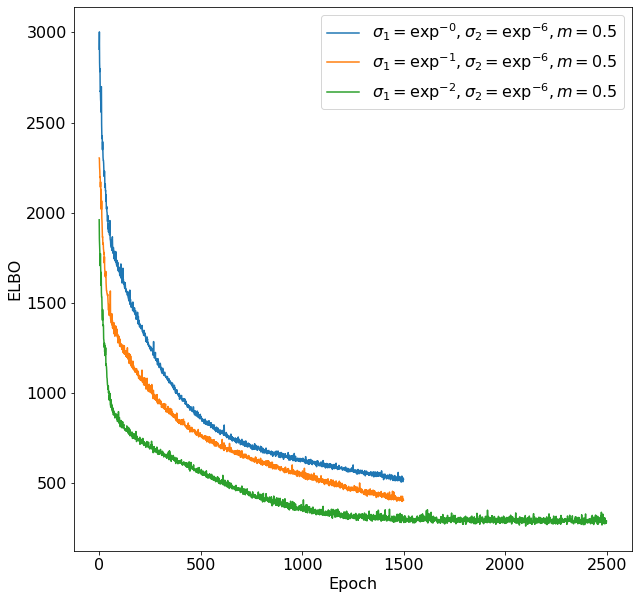

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))

for model in ['bnn_sigma_1_exp_0_sigma_2_exp_6_m50', 'bnn_sigma_1_exp_1_sigma_2_exp_6_m50', 'bnn_sigma_1_exp_2_sigma_2_exp_6_m50']:
# for model in ['bnn_sigma_1_exp_0_sigma_2_exp_7_m50', 'bnn_sigma_1_exp_1_sigma_2_exp_7_m50', 'bnn_sigma_1_exp_2_sigma_2_exp_7_m50']:
# for model in ['bnn_sigma_1_exp_0_sigma_2_exp_8_m50', 'bnn_sigma_1_exp_1_sigma_2_exp_8_m50', 'bnn_sigma_1_exp_2_sigma_2_exp_8_m50']:
    model_details = MODEL_DETAILS_DICT[model]
    loss = np.load(os.path.join(model_details.dir, 'loss.npy'))
    ax.plot(loss, label=model_details.label)
ax.legend()
ax.set_xlabel('Epoch')
ax.set_ylabel('ELBO')

Text(0, 0.5, 'ELBO')

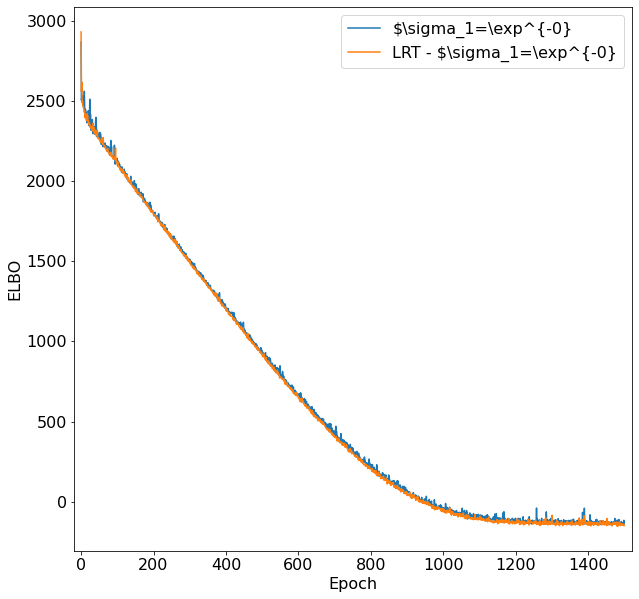

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))

for model in ['bnn_sigma_1_exp_0_1', 'bnn_lrt_sigma_1_exp_0']:
    model_details = MODEL_DETAILS_DICT[model]
    loss = np.load(os.path.join(model_details.dir, 'loss.npy'))
    ax.plot(loss, label=model_details.label)
ax.legend()
ax.set_xlim(-20,1520)
ax.set_xlabel('Epoch')
ax.set_ylabel('ELBO')

Text(0, 0.5, 'ELBO')

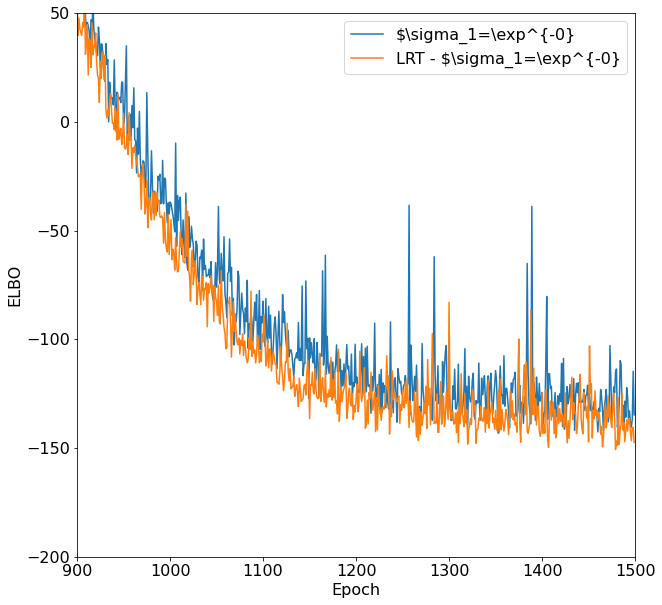

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))

for model in ['bnn_sigma_1_exp_0_1', 'bnn_lrt_sigma_1_exp_0']:
    model_details = MODEL_DETAILS_DICT[model]
    loss = np.load(os.path.join(model_details.dir, 'loss.npy'))
    ax.plot(loss, label=model_details.label)
ax.set_xlim(900, 1500)
ax.set_ylim(-200, 50)
ax.legend()
ax.set_xlabel('Epoch')
ax.set_ylabel('ELBO')

Text(0, 0.5, 'RMSE')

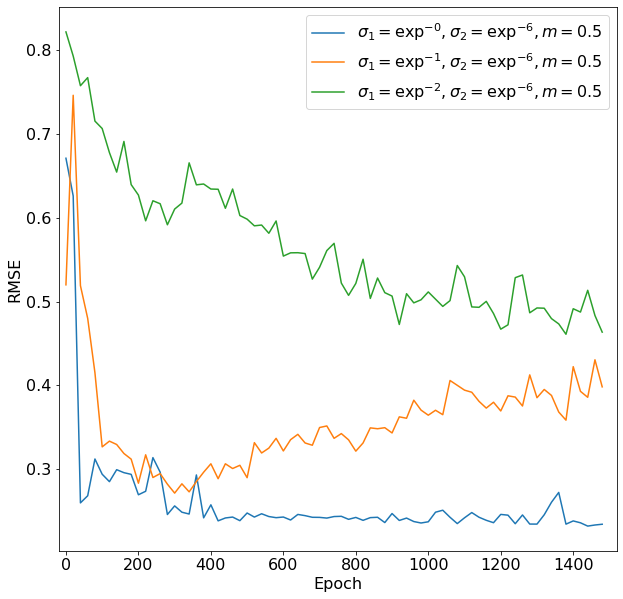

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))

for model in ['bnn_sigma_1_exp_0_sigma_2_exp_6_m50', 'bnn_sigma_1_exp_1_sigma_2_exp_6_m50', 'bnn_sigma_1_exp_2_sigma_2_exp_6_m50']:
# for model in ['bnn_sigma_1_exp_0_sigma_2_exp_7_m50', 'bnn_sigma_1_exp_1_sigma_2_exp_7_m50', 'bnn_sigma_1_exp_2_sigma_2_exp_7_m50']:
# for model in ['bnn_sigma_1_exp_0_sigma_2_exp_8_m50', 'bnn_sigma_1_exp_1_sigma_2_exp_8_m50', 'bnn_sigma_1_exp_2_sigma_2_exp_8_m50']:
    model_details = MODEL_DETAILS_DICT[model]
    eval_metric = np.load(os.path.join(model_details.dir, 'eval_metric.npy'))
    ax.plot(np.arange(0,1500,20), eval_metric, label=model_details.label)
ax.legend()
ax.set_xlim(-20,1520)
ax.set_xlabel('Epoch')
ax.set_ylabel('RMSE')

Text(0, 0.5, 'RMSE')

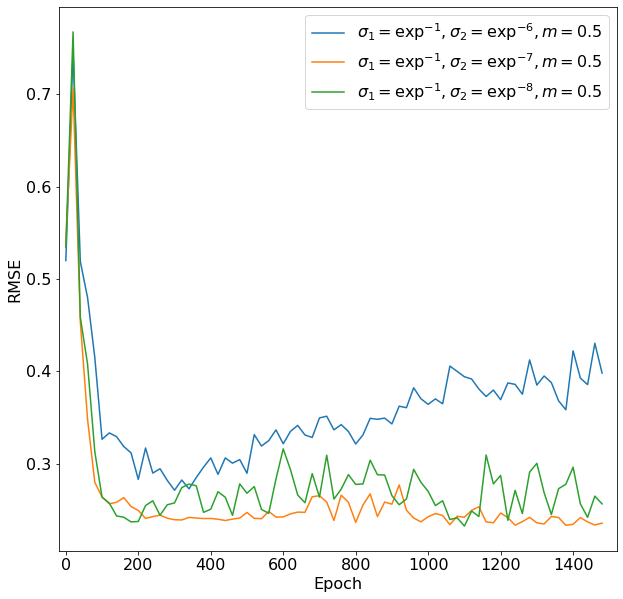

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))

for model in ['bnn_sigma_1_exp_1_sigma_2_exp_6_m50', 'bnn_sigma_1_exp_1_sigma_2_exp_7_m50', 'bnn_sigma_1_exp_1_sigma_2_exp_8_m50']:
    model_details = MODEL_DETAILS_DICT[model]
    eval_metric = np.load(os.path.join(model_details.dir, 'eval_metric.npy'))
    ax.plot(np.arange(0,1500,20), eval_metric, label=model_details.label)
ax.legend()
ax.set_xlim(-20,1520)
ax.set_xlabel('Epoch')
ax.set_ylabel('RMSE')

KeyError: 'bnn_lrt_sigma_1_exp_2_sigma_2_exp_6_m50'

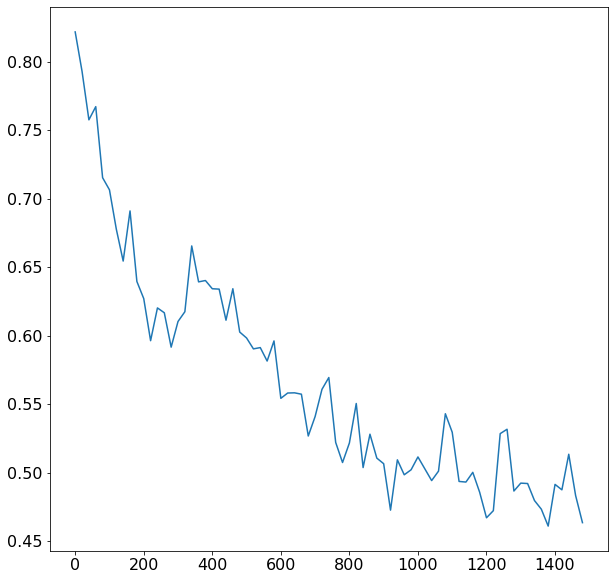

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))

for model in ['bnn_sigma_1_exp_2_sigma_2_exp_6_m50', 'bnn_lrt_sigma_1_exp_2_sigma_2_exp_6_m50',]:
    model_details = MODEL_DETAILS_DICT[model]
    eval_metric = np.load(os.path.join(model_details.dir, 'eval_metric.npy'))
    ax.plot(np.arange(0,1500,20), eval_metric, label=model_details.label)
ax.legend()
ax.set_xlabel('Epoch')
ax.set_ylabel('RMSE')

KeyError: 'bnn_lrt_sigma_1_exp_2_sigma_2_exp_6_m50'

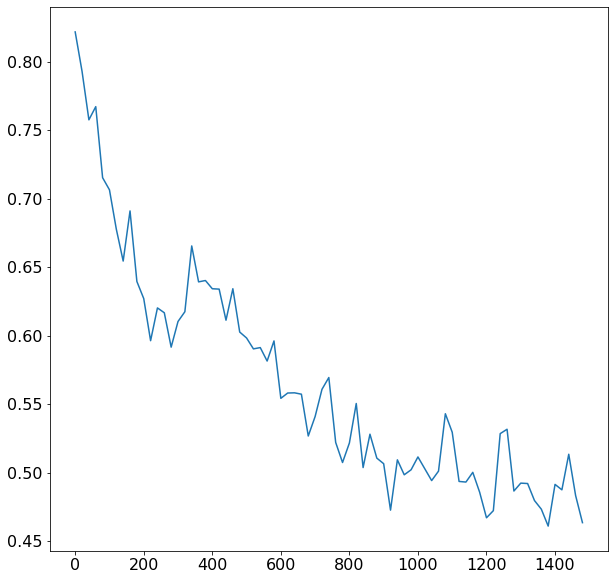

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))

for model in ['bnn_sigma_1_exp_2_sigma_2_exp_6_m50', 'bnn_lrt_sigma_1_exp_2_sigma_2_exp_6_m50',]:
    model_details = MODEL_DETAILS_DICT[model]
    eval_metric = np.load(os.path.join(model_details.dir, 'eval_metric.npy'))
    ax.plot(np.arange(0,1500,20), eval_metric, label=model_details.label)
ax.legend()
ax.set_xlim(-20,1520)
ax.set_xlabel('Epoch')
ax.set_ylabel('RMSE')

## LPD

### BNN

In [65]:
MODEL = "bnn_sigma_1_exp_2_sigma_2_exp_6_m50"
MODEL_DETAILS = MODEL_DETAILS_DICT[MODEL]

In [66]:
with open(os.path.join(MODEL_DETAILS.dir, 'params.txt'), 'r') as f:
    bnn_params_dict = json.load(f)

# Need to deserialise the prior_params into a PriorParameters object
if bnn_params_dict['prior_params']:
    bnn_params_dict['prior_params'] = PriorParameters(**bnn_params_dict['prior_params'])

bnn_params = Parameters(**bnn_params_dict)

bnn_net = MODEL_DETAILS.mclass(params=bnn_params, eval_mode=True)
bnn_net.model.load_state_dict(torch.load(os.path.join(MODEL_DETAILS.dir, 'model.pt'), map_location=torch.device(DEVICE)))
bnn_net.model.to(DEVICE)

bnn_net.inference_samples = 10

2022-03-27 19:19:56,057 - bbb.models.layers - INFO - Weights Prior: Gaussian mixture with means (0, 0), variances (0.1353352832366127, 0.0024787521766663585) and weight 0.5
2022-03-27 19:19:56,057 - bbb.models.layers - INFO - Biases Prior: Gaussian mixture with means (0, 0), variances (0.1353352832366127, 0.0024787521766663585) and weight 0.5
2022-03-27 19:19:56,061 - bbb.models.layers - INFO - Weights Prior: Gaussian mixture with means (0, 0), variances (0.1353352832366127, 0.0024787521766663585) and weight 0.5
2022-03-27 19:19:56,063 - bbb.models.layers - INFO - Biases Prior: Gaussian mixture with means (0, 0), variances (0.1353352832366127, 0.0024787521766663585) and weight 0.5
2022-03-27 19:19:56,065 - bbb.models.layers - INFO - Weights Prior: Gaussian mixture with means (0, 0), variances (0.1353352832366127, 0.0024787521766663585) and weight 0.5
2022-03-27 19:19:56,065 - bbb.models.layers - INFO - Biases Prior: Gaussian mixture with means (0, 0), variances (0.1353352832366127, 0.0

In [67]:
# bnn_net.lpd(test_data.dataset[:][0], test_data.dataset[:][1])

In [68]:
bnn_pred_mean, bnn_pred_var, bnn_pred_quartiles = bnn_net.predict(test_data.dataset[:][0])
bnn_pred_mean = bnn_pred_mean.cpu().detach().numpy().flatten()
bnn_pred_var = bnn_pred_var.cpu().detach().numpy().flatten()
bnn_pred_quartiles = bnn_pred_quartiles.cpu().detach().numpy().squeeze()
bnn_pred_std = np.sqrt(bnn_pred_var)

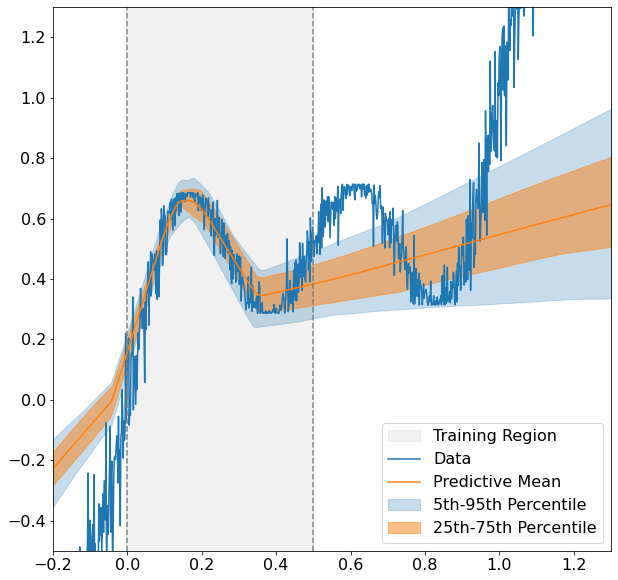

In [69]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.fill_betweenx(np.array((-100, 100)), train_data.dataset[:][0].min(), train_data.dataset[:][0].max(), color='tab:gray', alpha=0.1, label='Training Region')
ax.plot(input_np, output_np, label='Data')
ax.plot(input_np, bnn_pred_mean, label='Predictive Mean')
# ax.fill_between(input_np, bnn_pred_mean-2*bnn_pred_std, bnn_pred_mean+2*bnn_pred_std, color='green', alpha=0.5, label='Predictive Mean')
ax.fill_between(input_np, bnn_pred_quartiles[0,:], bnn_pred_quartiles[3,:], color='tab:blue', alpha=0.25,  label='5th-95th Percentile')
ax.fill_between(input_np, bnn_pred_quartiles[1,:], bnn_pred_quartiles[2,:], color='tab:orange', alpha=0.5,  label='25th-75th Percentile')
ax.axvline(train_data.dataset[:][0].min(), ls='--', c='gray')
ax.axvline(train_data.dataset[:][0].max(), ls='--', c='gray')
ax.set_xlim([-0.2, 1.3])
ax.set_ylim([-0.5, 1.3])
ax.legend()

In [70]:
bnn_lpd_vals = np.zeros_like(input_np)
for i in range(len(input_np)):
    bnn_lpd_vals[i] = scp_norm(bnn_pred_mean[i], bnn_pred_std[i]).logpdf(output_np[i])
bnn_lpd_vals.mean(), np.exp(bnn_lpd_vals.mean())

(-5.0063186, 0.006695507)

In [22]:
# del bnn_pred_mean
# del bnn_pred_var
# del bnn_pred_quartiles
# torch.cuda.empty_cache()

In [23]:
sigma_1_range = np.array((0,1,2))
sigma_2_range = np.array((6,7,8))

In [115]:
bnn_lpd_group_vals = np.zeros((len(sigma_1_range), len(sigma_2_range)))

for idx, model in enumerate(BNN_MODELS):
    model_details = MODEL_DETAILS_DICT[model]

    if model_details.lrt:
        continue
    
    # Load params
    with open(os.path.join(model_details.dir, 'params.txt'), 'r') as f:
        params_dict = json.load(f)

    # Need to deserialise the prior_params into a PriorParameters object
    if params_dict['prior_params']:
        params_dict['prior_params'] = PriorParameters(**params_dict['prior_params'])

    params = Parameters(**params_dict)

    # Load model
    net = MODEL_DETAILS.mclass(params=params, eval_mode=True)
    net.model.load_state_dict(torch.load(os.path.join(model_details.dir, 'model.pt'), map_location=torch.device(DEVICE)))
    net.model.to(DEVICE)

    net.inference_samples = 1000
    bnn_pred_mean, bnn_pred_var, _ = net.predict(test_data.dataset[:][0])
    bnn_pred_mean = bnn_pred_mean.cpu().detach().numpy().flatten()
    bnn_pred_var = bnn_pred_var.cpu().detach().numpy().flatten()
    bnn_pred_std = np.sqrt(bnn_pred_var)

    del net
    torch.cuda.empty_cache()

    lpd_vals = np.zeros_like(input_np)
    for i in range(len(input_np)):
        lpd_vals[i] = scp_norm(bnn_pred_mean[i], bnn_pred_std[i]).logpdf(output_np[i])
    
    bnn_lpd_group_vals[
        np.argwhere(sigma_1_range==int(-np.log(model_details.s1)))[0][0], np.argwhere(sigma_2_range==int(-np.log(model_details.s2)))[0][0]
    ]=lpd_vals.mean()

bnn_lpd_group_vals

2022-03-27 16:21:40,775 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 1.0
2022-03-27 16:21:40,776 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 1.0
2022-03-27 16:21:40,779 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 1.0
2022-03-27 16:21:40,780 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 1.0
2022-03-27 16:21:40,781 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 1.0
2022-03-27 16:21:40,781 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 1.0
2022-03-27 16:21:58,537 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 1.0
2022-03-27 16:21:58,537 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 1.0
2022-03-27 16:21:58,540 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 1.0
2022-03-27 16:21:58,540 - bbb.models.layers - INFO

array([[-0.27444792, -0.25211629, -0.34113613],
       [ 0.03206235,  0.14062463, -0.10834491],
       [-2.94667816, -2.75788045, -6.01030827]])

Text(0, 0.5, '$\\sigma_1$')

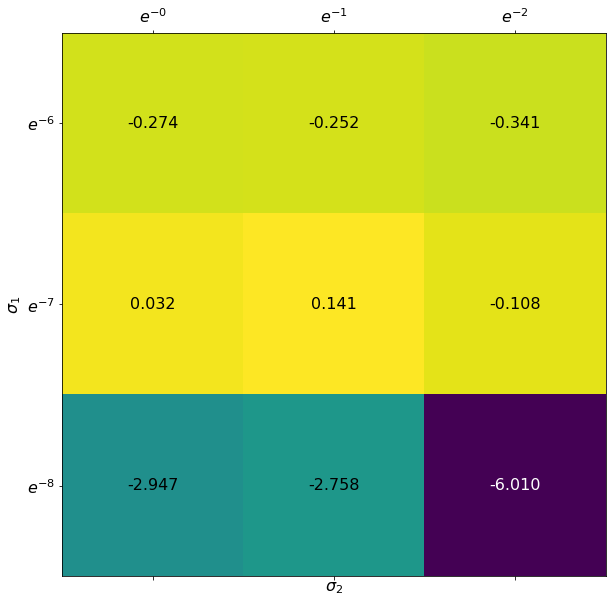

In [118]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))

ax.matshow(bnn_lpd_group_vals)

for (i, j), z in np.ndenumerate(bnn_lpd_group_vals):
    c = 'w' if i==2 and j==2 else 'k'
    ax.text(j, i, '{:0.3f}'.format(z), ha='center', va='center', color=c)

xaxis = np.arange(len(sigma_1_range))
ax.set_xticks(xaxis)
ax.set_yticks(xaxis)
ax.set_xticklabels(list(fr'$e^{{-{i}}}$' for i in sigma_1_range))
ax.set_yticklabels(list(fr'$e^{{-{i}}}$' for i in sigma_2_range))
ax.set_xlabel(r'$\sigma_2$')
ax.set_ylabel(r'$\sigma_1$')

### DNN

In [60]:
MODEL = "dnn_baseline_1"
MODEL_DETAILS = MODEL_DETAILS_DICT[MODEL]

with open(os.path.join(MODEL_DETAILS.dir, 'params.txt'), 'r') as f:
    dnn_params_dict = json.load(f)

# Need to deserialise the prior_params into a PriorParameters object
if dnn_params_dict['prior_params']:
    dnn_params_dict['prior_params'] = PriorParameters(**dnn_params_dict['prior_params'])

dnn_params = Parameters(**dnn_params_dict)

dnn_net = MODEL_DETAILS.mclass(params=dnn_params, eval_mode=True)
dnn_net.model.load_state_dict(torch.load(os.path.join(MODEL_DETAILS.dir, 'model.pt'), map_location=torch.device(DEVICE)))

<All keys matched successfully>

In [61]:
# dnn_net.lpd(test_data.dataset[:][0], test_data.dataset[:][1])

In [62]:
dnn_baseline_model_dirs = glob('../saved_models/DNN_regression/baseline/*')
dnn_do_50_model_dirs = glob('../saved_models/DNN_regression/dropout/0.5/*')
dnn_do_75_model_dirs = glob('../saved_models/DNN_regression/dropout/0.75/*')

dnn_model_dir = dnn_do_50_model_dirs

In [63]:
dnn_baseline_preds = np.zeros((len(dnn_model_dir), train_data.dataset[:][0].shape[0]))

for i, model in enumerate(dnn_model_dir):    
    # Load params
    with open(os.path.join(model, 'params.txt'), 'r') as f:
        params_dict = json.load(f)

    # Need to deserialise the prior_params into a PriorParameters object
    if params_dict['prior_params']:
        params_dict['prior_params'] = PriorParameters(**params_dict['prior_params'])

    params = Parameters(**params_dict)

    # Load model
    net = RegressionDNN(params=params, eval_mode=True)
    net.model.load_state_dict(torch.load(os.path.join(model, 'model.pt'), map_location=torch.device(DEVICE)))
    net.model.to(DEVICE)

    preds, _, _ = net.predict(test_data.dataset[:][0])
    preds = preds.detach().cpu().numpy().flatten()
    
    dnn_baseline_preds[i, :] = preds

In [64]:
dnn_pred_mean = dnn_baseline_preds.mean(axis=0)
dnn_pred_var = dnn_baseline_preds.var(axis=0)
dnn_pred_std = dnn_baseline_preds.std(axis=0)

dnn_pred_5_quart = np.quantile(dnn_baseline_preds, 0.05, axis=0)
dnn_pred_25_quart = np.quantile(dnn_baseline_preds, 0.25, axis=0)
dnn_pred_75_quart = np.quantile(dnn_baseline_preds, 0.75, axis=0)
dnn_pred_95_quart = np.quantile(dnn_baseline_preds, 0.95, axis=0)

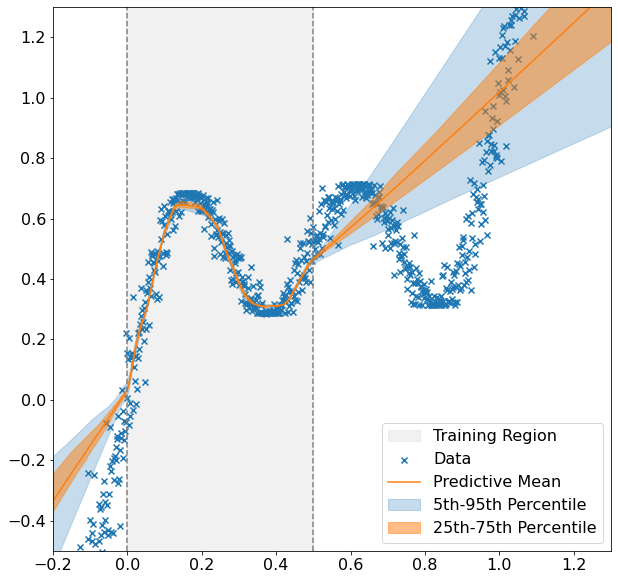

In [65]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.fill_betweenx(np.array((-100, 100)), train_data.dataset[:][0].min(), train_data.dataset[:][0].max(), color='tab:gray', alpha=0.1, label='Training Region')
ax.scatter(input_np, output_np, label='Data', marker='x')
ax.plot(input_np, dnn_pred_mean, label='Predictive Mean', c='tab:orange')
# ax.fill_between(input_np, dnn_pred_mean-2*dnn_pred_std, dnn_pred_mean+2*dnn_pred_std, label='Predictive Mean', color='tab:orange', alpha=0.5)
ax.fill_between(input_np, dnn_pred_5_quart, dnn_pred_95_quart, color='tab:blue', alpha=0.25,  label='5th-95th Percentile')
ax.fill_between(input_np, dnn_pred_25_quart, dnn_pred_75_quart, color='tab:orange', alpha=0.5,  label='25th-75th Percentile')
ax.axvline(train_data.dataset[:][0].min(), ls='--', c='gray')
ax.axvline(train_data.dataset[:][0].max(), ls='--', c='gray')
ax.set_xlim([-0.2, 1.3])
ax.set_ylim([-0.5, 1.3])
ax.legend()

In [66]:
dnn_lpd_vals = np.zeros_like(input_np)
for i in range(len(input_np)):
    dnn_lpd_vals[i] = scp_norm(dnn_pred_mean[i], dnn_pred_std[i]).logpdf(output_np[i])
dnn_lpd_vals.mean(), np.exp(dnn_lpd_vals.mean())

(-12.309811, 4.507307e-06)

## Evaluate Multiple Models

In [82]:
# models = ['bnn_baseline_1', 'dnn_baseline_1']
models = ['bnn_sigma_1_exp_2_1', 'bnn_sigma_1_exp_2_sigma_2_exp_6_m50', 'dnn_do_75_baseline', 'dnn_baseline_1']

2022-03-27 19:41:17,297 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 0.1353352832366127
2022-03-27 19:41:17,298 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 0.1353352832366127
2022-03-27 19:41:17,300 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 0.1353352832366127
2022-03-27 19:41:17,301 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 0.1353352832366127
2022-03-27 19:41:17,302 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 0.1353352832366127
2022-03-27 19:41:17,302 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 0.1353352832366127
2022-03-27 19:41:24,438 - bbb.models.layers - INFO - Weights Prior: Gaussian mixture with means (0, 0), variances (0.1353352832366127, 0.0024787521766663585) and weight 0.5
2022-03-27 19:41:24,439 - bbb.models.layers - INFO - Biases Prior: Gaussian mixture with means (0, 0), v

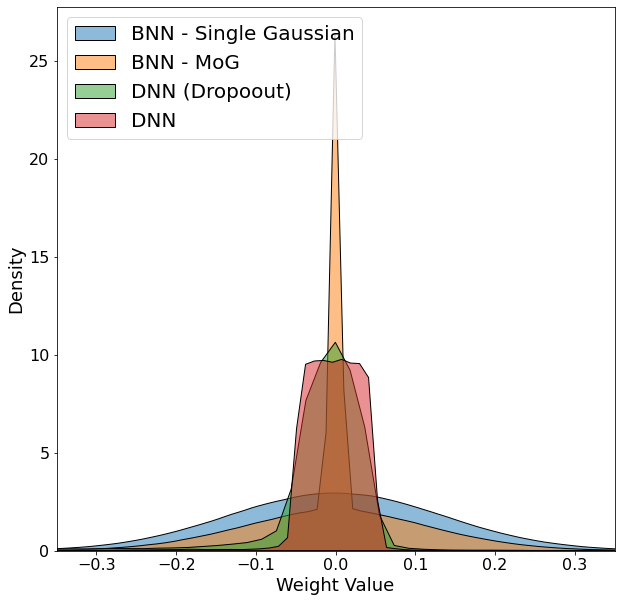

In [83]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
# Formatting of plot
ax.set_xlabel('Weight Value', fontsize=18)
ax.set_ylabel('Density', fontsize=18)


for idx, model in enumerate(models):
    MODEL_DETAILS = MODEL_DETAILS_DICT[model]
    
    # Load params
    with open(os.path.join(MODEL_DETAILS.dir, 'params.txt'), 'r') as f:
        params_dict = json.load(f)

    # Need to deserialise the prior_params into a PriorParameters object
    if params_dict['prior_params']:
        params_dict['prior_params'] = PriorParameters(**params_dict['prior_params'])

    params = Parameters(**params_dict)

    # Load model
    net = MODEL_DETAILS.mclass(params=params, eval_mode=True)
    net.model.load_state_dict(torch.load(os.path.join(MODEL_DETAILS.dir, 'model.pt'), map_location=torch.device(DEVICE)))
    net.model.to(DEVICE)

    weight_samples = net.weight_samples()

    comb_weight_samples = torch.hstack(weight_samples)
    sns.kdeplot(comb_weight_samples.flatten().detach().cpu().numpy(), fill=True, ax=ax, color=colors[idx], alpha=0.5, multiple="stack")
    # ax.hist(comb_weight_samples.flatten().detach().cpu().numpy(), **histogram_args)

    
# Display the plot
ax.legend(['BNN - Single Gaussian', 'BNN - MoG', 'DNN (Dropoout)', 'DNN'], loc='upper left', prop={'size':20})
ax.set_xlim(-0.35, 0.35)
plt.savefig(os.path.join("../plots/bbb_regression/baseline/comb_weights_plot.png"), pad_inches=0.2, bbox_inches='tight')
plt.show()

In [141]:
# models = ['bnn_baseline_1', 'dnn_baseline_1']
models = [
    'bnn_sigma_1_exp_0_sigma_2_exp_6_m50',
    # 'bnn_sigma_1_exp_0_sigma_2_exp_7_m50',
    # 'bnn_sigma_1_exp_0_sigma_2_exp_8_m50',
    'bnn_sigma_1_exp_1_sigma_2_exp_6_m50',
    # 'bnn_sigma_1_exp_1_sigma_2_exp_7_m50',
    # 'bnn_sigma_1_exp_1_sigma_2_exp_8_m50',
    'bnn_sigma_1_exp_2_sigma_2_exp_6_m50',
    # 'bnn_sigma_1_exp_2_sigma_2_exp_7_m50',
    # 'bnn_sigma_1_exp_2_sigma_2_exp_8_m50',
]

2022-03-27 14:19:56,749 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 1.0
2022-03-27 14:19:56,750 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 1.0
2022-03-27 14:19:56,754 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 1.0
2022-03-27 14:19:56,755 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 1.0
2022-03-27 14:19:56,756 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 1.0
2022-03-27 14:19:56,757 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 1.0
2022-03-27 14:20:03,328 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 0.36787944117144233
2022-03-27 14:20:03,329 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 0.36787944117144233
2022-03-27 14:20:03,332 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 0.36787944117144233
20

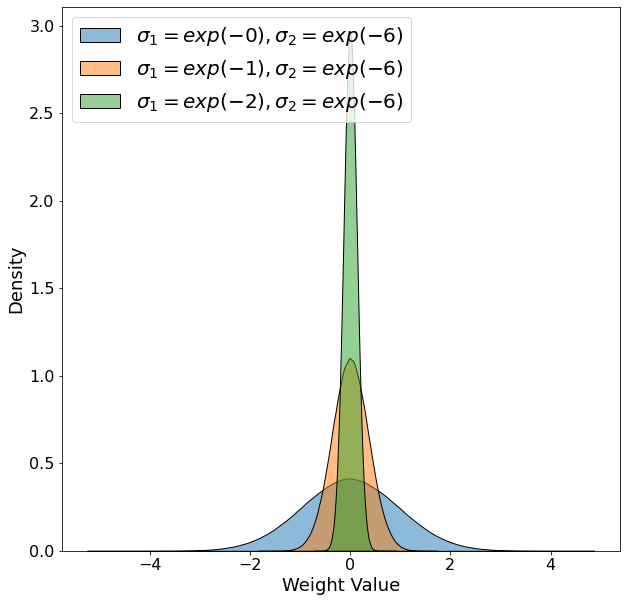

In [142]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
# Formatting of plot
ax.set_xlabel('Weight Value', fontsize=18)
ax.set_ylabel('Density', fontsize=18)


for idx, model in enumerate(models):
    MODEL_DETAILS = MODEL_DETAILS_DICT[model]
    
    # Load params
    with open(os.path.join(MODEL_DETAILS.dir, 'params.txt'), 'r') as f:
        params_dict = json.load(f)

    # Need to deserialise the prior_params into a PriorParameters object
    if params_dict['prior_params']:
        params_dict['prior_params'] = PriorParameters(**params_dict['prior_params'])

    params = Parameters(**params_dict)

    # Load model
    net = MODEL_DETAILS.mclass(params=params, eval_mode=True)
    net.model.load_state_dict(torch.load(os.path.join(MODEL_DETAILS.dir, 'model.pt'), map_location=torch.device(DEVICE)))

    weight_samples = net.weight_samples()

    comb_weight_samples = torch.hstack(weight_samples)
    sns.kdeplot(comb_weight_samples.flatten().detach().cpu().numpy(), fill=True, ax=ax, color=colors[idx], alpha=0.5, multiple="stack")
    # ax.hist(comb_weight_samples.flatten().detach().cpu().numpy(), **histogram_args)

    
# Display the plot
ax.legend([
    r'$\sigma_1=exp(-0), \sigma_2=exp(-6)$',
    # r'$\sigma_1=exp(-0), \sigma_2=exp(-7)$',
    # r'$\sigma_1=exp(-0), \sigma_2=exp(-8)$',
    r'$\sigma_1=exp(-1), \sigma_2=exp(-6)$',
    # r'$\sigma_1=exp(-1), \sigma_2=exp(-7)$',
    # r'$\sigma_1=exp(-1), \sigma_2=exp(-8)$',
    r'$\sigma_1=exp(-2), \sigma_2=exp(-6)$',
    # r'$\sigma_1=exp(-2), \sigma_2=exp(-7)$',
    # r'$\sigma_1=exp(-2), \sigma_2=exp(-8)$',
], loc='upper left', prop={'size':20})
plt.savefig(os.path.join("../plots/bbb_regression/baseline/comb_weights_plot.png"), pad_inches=0.2, bbox_inches='tight')
plt.show()